# Breast Cancer Spatial Analysis with MultiGATE

This notebook demonstrates spatial clustering analysis of breast cancer data using MultiGATE.

## 1. Setup and Data Loading

In [4]:
# Import required libraries
import scanpy as sc
import matplotlib.pyplot as plt
import sys

# Add MultiGATE to path and import
sys.path.insert(0, '/lustre/project/Stat/s1155202250/fastfolder/code/st/MultiGATE/MultiGATEgithub0607/tutorial_notebooks')
import MultiGATE 

In [5]:
# Load pre-processed breast cancer data
adata1 = sc.read_h5ad('./breastcancerResults/breastcancer_adata.h5ad')
adata1



AnnData object with n_obs × n_vars = 4169 × 3000
    obs: 'wnn', 'wnn_clusters'
    uns: 'wnn_clusters_colors', 'wnn_colors'
    obsm: 'MultiGATE', 'MultiGATE_RNA', 'MultiGATE_protein', 'X_umap', 'X_umap_wnn', 'spatial'

In [6]:
# Prepare MultiGATE embeddings for RNA modality
adata1.obsm['MultiGATE_RNA'] = adata1.obsm['MultiGATE']

## 2. Clustering Function

This section defines the WNN (Weighted Nearest Neighbors) clustering function using Seurat through rpy2.


In [7]:
# Configure R environment for Seurat
import os
os.environ['R_HOME'] = "/lustre/project/Stat/s1155077016/condaenvs/Seurat4/lib/R" 
os.environ['R_USER'] = '/users/s1155077016/anaconda3/lib/python3.9/site-packages/rpy2'

def wnn_R(adata, res=0.5, algo=1, used_obsm='MultiGATE_RNA', used_obsm2='MultiGATE_protein'):
    """
    Perform clustering using Seurat's WNN algorithm on MultiGATE embeddings.
    
    Parameters:
    - adata: AnnData object with MultiGATE embeddings
    - res: Resolution for clustering
    - algo: Clustering algorithm
    - used_obsm: RNA embedding key
    - used_obsm2: Protein embedding key
    """
    import rpy2.robjects as ro
    ro.r.library("Seurat")
    ro.r.library("ggplot2")
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    import rpy2.robjects.pandas2ri
    rpy2.robjects.pandas2ri.activate()
    
    # Extract embeddings
    data1 = adata.obsm[used_obsm]
    data2 = adata.obsm[used_obsm2]

    # Convert to R format
    rna_matrix = rpy2.robjects.numpy2ri.numpy2rpy(data1)
    protein_matrix = rpy2.robjects.numpy2ri.numpy2rpy(data2)
    barcodes = rpy2.robjects.pandas2ri.py2rpy(adata.obs.index)

    # Setup R variables
    ro.r.assign("rna_matrix", rna_matrix)
    ro.r.assign("protein_matrix", protein_matrix)
    ro.r.assign("barcodes", barcodes)
    ro.r.assign("res", res)
    ro.r.assign("algo", algo)

    # Execute Seurat WNN pipeline
    ro.r(
    '''
    colnames(rna_matrix) <- paste0("pca_", 1:30)
    colnames(protein_matrix) <- paste0("lsi_", 1:30)
    rownames(rna_matrix) <- barcodes
    rownames(protein_matrix) <- barcodes

    # Create Seurat object with both modalities
    P22 <- CreateSeuratObject(counts = t(rna_matrix))
    protein_obj <- CreateAssayObject(counts = t(protein_matrix))
    P22[["PROTEIN"]] <- protein_obj
    
    # Add dimension reductions
    P22[["pca"]] = CreateDimReducObject(embeddings = rna_matrix, key = "pca_", assay = "RNA")
    P22[["lsi"]] = CreateDimReducObject(embeddings = protein_matrix, key = "lsi_", assay = "PROTEIN")
    
    # WNN analysis
    P22 <- FindMultiModalNeighbors(P22, reduction.list = list("pca", "lsi"), dims.list = list(1:30, 1:30))
    P22 <- RunUMAP(P22, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
    P22 <- FindClusters(P22, graph.name = "wsnn", algorithm = algo, resolution = res, verbose = FALSE)
    
    # Extract results
    clusters = P22@meta.data$seurat_clusters 
    wwnumap = P22[["wnn.umap"]]
    umap = Embeddings(object = wwnumap)
    '''
    )
    
    # Import results back to Python
    wnn_UMAP = ro.r('umap')
    wnn = ro.r('clusters')
    
    # Update AnnData object
    adata.obs['wnn'] = wnn
    adata.obs['wnn'] = adata.obs['wnn'].astype('int')
    adata.obs['wnn'] = adata.obs['wnn'].astype('category')
    adata.obsm['X_umap'] = wnn_UMAP
    
    return adata

## 3. Clustering Analysis

Run WNN clustering on the breast cancer data using optimized resolution.

In [8]:
# Apply WNN clustering with resolution 0.23 for optimal cluster separation
MultiGATE_adata = wnn_R(adata1, res=0.23)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: 23:07:17 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: 23:07:17 Commencing smooth kNN distance calibration using 1 thread

R[write to console]: 23:07:18 Initializing from normalized Laplacian + noise

R[write to console]: 23:07:18 Commencing optimization for 500 epochs, with 117064 positive edges

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[wri

## 4. Spatial Visualization

Visualize the clustering results on spatial coordinates.

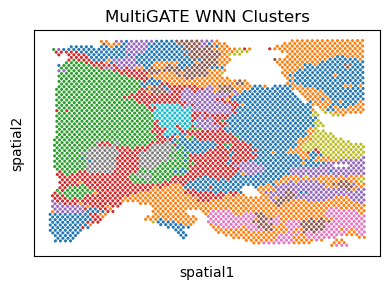

In [9]:
# Create spatial plot with WNN clusters
size = 20
plt.rcParams["figure.figsize"] = (4, 3) 
sc.pl.embedding(adata1, basis='spatial', color='wnn', title='MultiGATE WNN Clusters', 
                s=size, show=False, legend_loc=None)

plt.tight_layout()
plt.show()


## 5. Data Summary and Export

Review the final data structure and save results.


In [10]:
# Display final data structure with clustering results
adata1

AnnData object with n_obs × n_vars = 4169 × 3000
    obs: 'wnn', 'wnn_clusters'
    uns: 'wnn_clusters_colors', 'wnn_colors'
    obsm: 'MultiGATE', 'MultiGATE_RNA', 'MultiGATE_protein', 'X_umap', 'X_umap_wnn', 'spatial'

In [11]:
# Save updated data with clustering results
adata1.write_h5ad('./breastcancerResults/breastcancer_adata.h5ad')